# Vision RAG: Enabling Search on Any Documents

In this notebook, you will learn how to implement Vision RAG applications using Voyage AI's multimodal embedding models and Anthropic's vision-capable LLMs.

Vision RAG is especially useful for extracting information from complex documents like PDFs, slide decks, and figures. With Voyage AI’s multimodal embeddings, retrieval works on both text and images, including screenshots of those documents. Paired with vision-capable LLMs, this extends traditional text-based RAG into Vision RAG, enabling retrieval and reasoning that go beyond text alone.

To showcase the power of multimodal embeddings and vision-capable LLMs, we’ll extract rich image content containing text, figures, and diagrams from the latest GitHub Octoverse survey. You can find the survey here: [GitHub Octoverse 2025](https://github.blog/news-insights/octoverse/octoverse-a-new-developer-joins-github-every-second-as-ai-leads-typescript-to-1/).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/rag/vision_rag_voyageai_claude.ipynb)

If you want a full end-to-end example using MongoDB as a vector store and GCP for storing image files, see this tutorial: [Building Multimodal AI Applications with MongoDB, Voyage AI, and Gemini](https://dev.to/mongodb/building-multimodal-ai-applications-with-mongodb-voyage-ai-and-gemini-49g3).

## Step 1: Install necessary libraries

First, we need to set up our Python environment. We will install the **voyageai** client for generating embeddings and the **anthropic** client for the generative model.

In [1]:
!pip install -qU voyageai anthropic


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Step 2: Initialize API clients

To interact with the models, you must initialize the client objects with your API keys. You will need a Voyage AI API key (for the voyage-multimodal-3 model) and an Anthropic API key (for sonnet-4.5 or similar).

*Note: It is best practice to use environment variables or a secret manager rather than hardcoding keys in production.*

In [16]:
import anthropic
from voyageai import Client

voyage_api_key = ""  # get an api key https://www.voyageai.com/
anthropic_api_key = ""  # get an api key https://platform.claude.com/

vo = Client(api_key=voyage_api_key)
client = anthropic.Anthropic(api_key=anthropic_api_key)

## Step 3: Extract visual content

For this example, we will scrape charts and infographics directly from the GitHub Octoverse blog post. In a production setting, this step might involve converting PDF pages to images or processing a directory of PNGs.
We’ll start by importing the standard utilities we need for web requests, image processing, and math operations.

In [3]:
import os

import numpy as np
import requests
from bs4 import BeautifulSoup
from PIL import Image

Next, we define a helper function `extract_image_urls` to parse the article’s HTML and grab image links, filtering out small icons or logos.

In [4]:
def extract_image_urls(url):
    """Extract all image URLs from the GitHub Octoverse article."""
    try:
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        response.raise_for_status()

        soup = BeautifulSoup(response.content, "html.parser")

        # Extract unique image URLs, filtering out icons/logos
        image_urls = []
        for img in soup.find_all("img"):
            src = img.get("src") or img.get("data-src")
            if src and not any(
                x in src.lower() for x in ["icon", "logo", "avatar", "emoji"]
            ):
                # Normalize to absolute URL
                if src.startswith("//"):
                    src = "https:" + src
                elif src.startswith("/"):
                    src = "https://github.blog" + src

                if src not in image_urls:  # Avoid duplicates
                    image_urls.append(src)

        return image_urls

    except Exception as e:
        print(f"Error: {e}")
        return []

Now let’s run the extraction on the specific URL.

In [5]:
# The Octoverse survey contains many images and diagrams
article_url = "https://github.blog/news-insights/octoverse/octoverse-a-new-developer-joins-github-every-second-as-ai-leads-typescript-to-1/"

infographic_urls = extract_image_urls(article_url)

print("Fetching infographic URLs from GitHub Octoverse article...")
print(f"URL: {article_url}\n")

# Display results
if infographic_urls:
    print(f"Found {len(infographic_urls)} images:\n")
    for i, url in enumerate(infographic_urls, 1):
        print(f"{i}. {url}")
else:
    print("No infographic URLs found.")

Fetching infographic URLs from GitHub Octoverse article...
URL: https://github.blog/news-insights/octoverse/octoverse-a-new-developer-joins-github-every-second-as-ai-leads-typescript-to-1/

Found 38 images:

1. https://github.blog/wp-content/uploads/2024/06/AI-DarkMode-4.png?resize=800%2C425
2. https://github.blog/wp-content/uploads/2024/05/Enterprise-DarkMode-3.png?resize=800%2C425
3. https://github.blog/wp-content/uploads/2024/07/Screenshot-2024-07-23-at-8.42.45 AM.png?resize=800%2C425
4. https://github.blog/wp-content/uploads/2024/07/Screenshot-2024-07-23-at-8.43.47 AM.png?resize=800%2C425
5. https://github.blog/wp-content/uploads/2024/07/Screenshot-2024-07-23-at-8.44.23 AM.png?resize=800%2C425
6. https://github.blog/wp-content/uploads/2024/07/Screenshot-2024-07-23-at-8.46.23 AM.png?resize=800%2C425
7. https://github.blog/wp-content/uploads/2024/07/Screenshot-2024-07-23-at-8.47.04 AM.png?resize=800%2C425
8. https://github.blog/wp-content/uploads/2025/10/octoverse-2025-hero-image.png

The scraping might still return general blog assets. To ensure high relevance, we will filter the list to only include images containing “octoverse-2025” in their URL, which targets the report’s charts.

In [6]:
octoverse_2025_urls = [url for url in infographic_urls if "octoverse-2025" in url]

print(f"Found {len(octoverse_2025_urls)} octoverse-2025 images:\n")
for i, url in enumerate(octoverse_2025_urls, 1):
    print(f"{i}. {url}")

Found 29 octoverse-2025 images:

1. https://github.blog/wp-content/uploads/2025/10/octoverse-2025-hero-image.png?resize=1600%2C850
2. https://github.blog/wp-content/uploads/2025/10/octoverse-2025-year-of-record-growth.png?resize=1152%2C288
3. https://github.blog/wp-content/uploads/2025/10/octoverse-2025-number-of-new-developers-on-github.png?resize=1728%2C972
4. https://github.blog/wp-content/uploads/2025/10/octoverse-2025-80-percent-of-new-devs-use-copilot-in-week-one.png?resize=1440%2C810
5. https://github.blog/wp-content/uploads/2025/10/octoverse-2025-developer-productivity-top-line-metrics.png?resize=1728%2C432
6. https://github.blog/wp-content/uploads/2025/10/octoverse-2025-open-source-contributions-by-type.png?resize=1024%2C576
7. https://github.blog/wp-content/uploads/2025/10/octoverse-2025-where-the-world-codes-top-line-metrics.png?resize=1728%2C432
8. https://github.blog/wp-content/uploads/2025/10/octoverse-2025-top-10-countries-on-github-1.jpeg?resize=1944%2C1094
9. https://g

## Step 4: Build the multimodal index

This is the core indexing step. We loop through our filtered URLs, download the images locally, and then pass them to Voyage AI’s `voyage-multimodal-3` model. This model converts the visual content into a dense vector embedding.

In [7]:
img_folder = "img"
os.makedirs(img_folder, exist_ok=True)


def download_and_embed(idx, url):
    """Download image and return its path and embedding."""
    # Extract filename from URL
    filename = url.split("/")[-1].split("?")[0]
    if "." not in filename:
        filename = f"infographic_{idx}.jpg"

    img_path = os.path.join(img_folder, filename)

    # Download if not cached
    if not os.path.exists(img_path):
        response = requests.get(url)
        response.raise_for_status()
        with open(img_path, "wb") as f:
            f.write(response.content)

    # Generate embedding
    pil_img = (
        Image.open(img_path).convert("RGBA").convert("RGB")
    )  # safely handle the transparency before converting to RGB
    result = vo.multimodal_embed(inputs=[[pil_img]], model="voyage-multimodal-3")

    return img_path, np.asarray(result.embeddings[0])


# Process all images
results = [download_and_embed(idx, url) for idx, url in enumerate(infographic_urls, 1)]
img_paths, doc_embeddings = zip(*results)
doc_embeddings = np.vstack(doc_embeddings)

print(f"First 3 embeddings (out of {len(doc_embeddings)}):")
print(doc_embeddings[:3])

First 3 embeddings (out of 38):
[[ 0.01434326 -0.03149414  0.00759888 ... -0.00411987 -0.00897217
  -0.02502441]
 [ 0.01721191  0.00854492  0.01452637 ...  0.0123291  -0.05688477
   0.02380371]
 [ 0.01525879 -0.00958252  0.04370117 ...  0.01385498 -0.02563477
  -0.00300598]]


## Step 5: Define RAG components

We need three specific capabilities to make our RAG pipeline work:
- **Image Encoding**: Converting images to base64 so they can be sent to the Anthropic API
- **Vector Retrieval**: Searching our array of embeddings to find the image most semantically similar to the user’s text query
- **Generation**: Sending the retrieved image and the user’s query to a VLM to get a natural language answer.

Let’s define helper functions for each.

In [18]:
import base64
import mimetypes

import PIL.Image


# Helper function needed to provide bas64 URL to Anthropic API
def image_to_data_url(img_path):
    """Convert image file to base64 data URL."""
    mime_type = mimetypes.guess_type(img_path)[0] or "image/png"
    with open(img_path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return f"data:{mime_type};base64,{b64}"


def vector_search(query):
    """Find most relevant image for the query using vector similarity."""
    # Embed the query
    result = vo.multimodal_embed(inputs=[[query]], model="voyage-multimodal-3")
    query_emb = np.asarray(result.embeddings[0])

    # Compute similarity and find top match
    # Voyage AI embeddings are normalized to length 1, which means that cosine similarity is equivalent to dot-product similarity
    cos_sim_scores = np.dot(doc_embeddings, query_emb)
    top_idx = int(np.argmax(cos_sim_scores))

    # Display result
    hit_img_path = img_paths[top_idx]
    print(f"Query: {query}")
    print(f"Most relevant image: {hit_img_path}")

    image = PIL.Image.open(hit_img_path)
    image.thumbnail((546, 546))
    display(image)

    return hit_img_path


def generate(query, img_path):
    """Generate response based on the image using Claude Sonnet."""

    # Read and encode image to base64
    with open(img_path, "rb") as image_file:
        image_data = base64.standard_b64encode(image_file.read()).decode("utf-8")

    # Determine media type from file extension
    media_type = mimetypes.guess_type(img_path)[0] or "image/jpeg"

    message = client.messages.create(
        model="claude-sonnet-4-20250514",
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": media_type,
                            "data": image_data,
                        },
                    },
                    {
                        "type": "text",
                        "text": f"Answer the question based on the image. Be succinct.\n\nQuery: {query}",
                    },
                ],
            }
        ],
    )

    return message.content[0].text

## Step 6: Combine the components into a complete pipeline

We can now wrap these steps into a single entry point, vision_rag. This function accepts a user query, performs the retrieval to find the correct chart, displays it, and then answers the question.

In [9]:
def vision_rag(query):
    """
    Perform vision-based RAG: search for relevant image and generate response.

    Args:
        query: The user's question or query string

    Returns:
        str: The generated response based on the most relevant image
    """

    img_path = vector_search(query)  # Vector search
    response = generate(query, img_path)  # Generation

    return response

## Step 7: Run queries

Let's test our pipeline. We will ask a specific question about developer communities. The system should identify the correct infographic from the report and read the data directly from it.

Query: What countries has the biggest developer communities?
Most relevant image: img/octoverse-2025-top-10-countries-on-github-1.jpeg


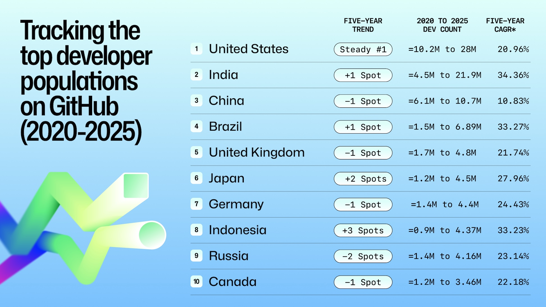

Based on the image, the countries with the biggest developer communities on GitHub (as of 2025) are:

1. **United States** - 28M developers
2. **India** - 21.9M developers  
3. **China** - 10.7M developers

The United States has maintained its position as #1 with the largest developer community, while India has risen to become the second-largest developer population on GitHub, showing significant growth from 4.5M to 21.9M developers between 2020-2025.


In [22]:
query = "What countries has the biggest developer communities?"

response = vision_rag(query)
print(response)

Now we can try a quantitative question regarding open-source repositories.

Query: How many open source repositories are there in 2025?
Most relevant image: img/octoverse-2025-open-source-growth-metrics.png


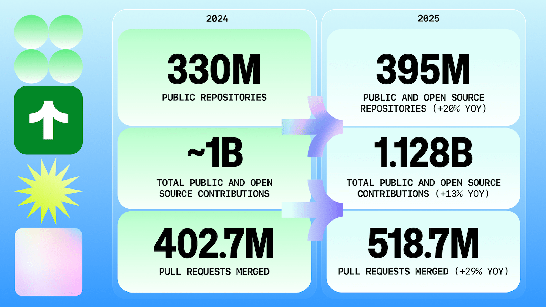

Based on the image, there are 395M public and open source repositories in 2025.


In [19]:
query = "How many open source repositories are there in 2025?"

response = vision_rag(query)
print(response)

And finally, a ranking question about programming languages.

Query: What are the top programming languages?
Most relevant image: img/octoverse-2025-top-programming-languages.png


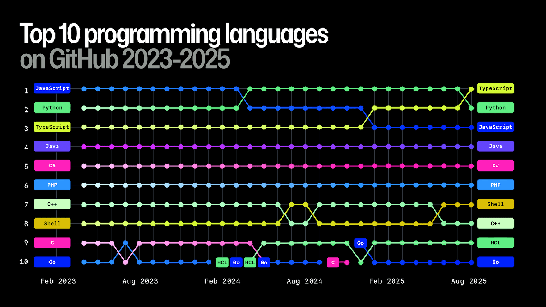

Based on the chart showing the top 10 programming languages on GitHub from 2023-2025, the top programming languages are:

1. **JavaScript** - Ranks #1 initially, then drops to #3 by 2025
2. **Python** - Starts at #2, briefly rises to #1, then settles at #2 
3. **TypeScript** - Begins at #3, rises significantly to become #1 by 2025
4. **Java** - Maintains a steady #4 position throughout the period
5. **C#** - Holds steady at #5
6. **PHP** - Remains consistently at #6
7. **C++** - Starts at #7, drops to #8 by 2025
8. **Shell** - Begins at #8, rises to #7 by 2025
9. **C** - Fluctuates but generally stays around #9, drops out of top 10 by 2025
10. **Go** - Starts at #10, with some fluctuation

The most notable trend is **TypeScript's dramatic rise** from #3 to #1, while **JavaScript and Python remain dominant** in the top 3 positions throughout the timeframe.


In [20]:
query = "What are the top programming languages?"

response = vision_rag(query)
print(response)

Query: Whats the top programming of 2025 in terms of contributors?
Most relevant image: img/octoverse-2025-top-programming-languages-metrics.png


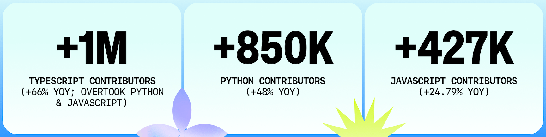

Based on the image, Python is the top programming language in 2025 in terms of contributors, with +850K contributors and a 48% year-over-year growth.


In [21]:
query = "Whats the top programming of 2025 in terms of contributors?"

response = vision_rag(query)
print(response)